In [1]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


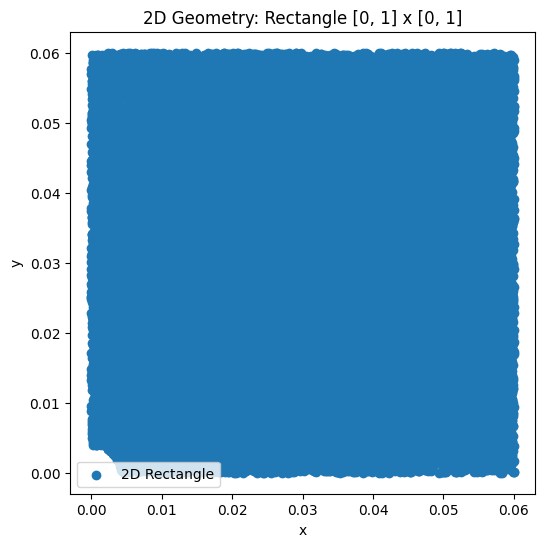

In [2]:
L = 6e-2
R= 4e-3
t_last=1e5
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)

geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


[[0.03683074 0.06       0.        ]
 [0.00418993 0.0014019  0.        ]
 [0.         0.04304139 0.        ]
 ...
 [0.0196509  0.05002435 0.        ]
 [0.02571437 0.         0.        ]
 [0.00834171 0.03007304 0.        ]]
[[ 4.34409294e+07]
 [ 1.01215721e+08]
 [ 4.33780251e+07]
 [ 7.58651581e+07]
 [ 6.10225716e+07]
 [ 4.43103828e+07]
 [-2.27972260e+07]
 [ 4.28259544e+07]
 [ 4.30763283e+07]
 [ 4.33262749e+07]
 [ 4.70284958e+07]
 [ 4.36959419e+07]
 [ 4.36870232e+07]
 [ 4.34758759e+07]
 [ 2.91532302e+06]
 [ 1.93439102e+06]
 [ 4.34617538e+07]
 [ 4.28608704e+07]
 [ 4.32766075e+07]
 [ 4.20406685e+07]
 [ 4.94299622e+07]
 [ 4.35964432e+07]
 [ 7.80474091e+07]
 [ 4.00814552e+07]
 [ 2.86288719e+07]
 [ 4.27726326e+07]
 [ 4.34808807e+07]
 [ 5.43453255e+07]
 [ 4.40080490e+07]
 [-9.75769520e+06]
 [ 4.33136749e+07]
 [ 4.29144478e+07]
 [ 7.54803467e+07]
 [ 4.35185661e+07]
 [ 2.10570660e+07]
 [ 4.12878952e+07]
 [ 5.66006241e+07]
 [ 4.34831429e+07]
 [ 2.37194061e+07]
 [ 4.34511299e+07]
 [ 4.34406395e+07]

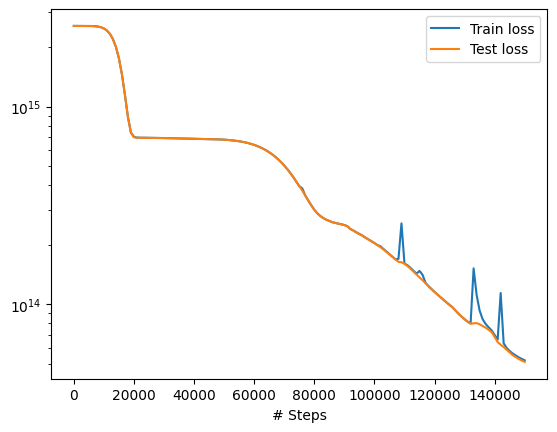

In [11]:

ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial, component=0)


# Read the entire Excel file
data_observe = pd.read_excel('Hydrostatic Data with Nodes.xlsx')  # Replace 'Stress.xlsx' with your actual file name
data_observe_sample = data_observe.sample(frac=0.15, random_state=42)  # random_state for reproducibility
x_observe = data_observe_sample[['x', 'y']].values  # Shape (N, 2)
t_observe = np.zeros((x_observe.shape[0], 1))  # Shape (N, 1)
x_observe = np.hstack((x_observe, t_observe))  # Now x_observe has shape (N, 3)
print(x_observe)
sigma_observe = data_observe_sample['sigma'].values.reshape(-1, 1)  # Shape (N, 1)
print(sigma_observe)
sigma_bc = dde.PointSetBC(x_observe, sigma_observe, component=1)

def pde_C_L(x, y):
    # Parameters D_L = 1, V_H = 1, RT = 1 are given
    D_L = 3.8e-11
    V_H = 2e-6
    RT= 8.314*298
    Coe=(D_L*V_H)/(RT)

    dC_L_dt = dde.grad.jacobian(y, x, i=0, j=2)  # ∂C_L/∂t (time derivative)
    CL_x=dde.grad.jacobian( y, x, i=0, j=0)
    CL_y=dde.grad.jacobian( y, x, i=0, j=1)
    CL_x2=dde.grad.hessian( y, x, i=0, j=0)
    CL_y2=dde.grad.hessian( y, x, i=0, j=1)

    grad_sigma_x2=dde.grad.jacobian(y,x,i=1,j=0)
    grad_sigma_y2= dde.grad.jacobian(y,x,i=1,j=1)
    grad_sigma_xx2=dde.grad.hessian(y,x,i=1,j=0)
    grad_sigma_yy2=dde.grad.hessian(y,x,i=1,j=1)
    grad_sigma_t=dde.grad.jacobian(y,x,i=1,j=2)

    C_L=y[:,0:1]
    eq1 =(dC_L_dt - D_L*(CL_x2+CL_y2)+(Coe)*(CL_x* grad_sigma_x2+C_L* grad_sigma_xx2+CL_y* grad_sigma_y2+C_L*grad_sigma_yy2))
    eq2= grad_sigma_t
    return [eq1, eq2]

data = dde.data.TimePDE(
    geomtime,
    pde_C_L, [ic,sigma_bc],
    num_boundary=1000,
    num_initial=1000,
    num_test=1000,
    )

# Network for C_L
layer_size = [3] + [64] * 8 + [2]  
activation = "relu"
initializer = "He normal"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-5,loss_weights=[1, 1,1, 1e0])
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=150000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [13]:
p=model.predict([[0.1,0.5,0.5]])
print(p)
p=model.predict([[0.1,0.2,0.8]])
print(p)
p=model.predict([[0.1,0.5,0.7]])
print(p)

[[-1.1920929e-07 -9.8086894e-06 -4.6231556e+00  4.1169830e+01
  -3.9448261e-01  2.0000000e+01]]
[[-1.1920929e-07 -9.8086894e-06 -4.6231556e+00  4.1169830e+01
  -3.9448261e-01  2.0000000e+01]]
[[-1.1920929e-07 -9.8086894e-06 -4.6231556e+00  4.1169830e+01
  -3.9448261e-01  2.0000000e+01]]


In [ ]:

import matplotlib.pyplot as plt
import imageio

# Assume you have already trained the model and now you're making predictions.

# Define the geometry (Square Plate)
L = 6e-2
geom = dde.geometry.Rectangle([0, 0], [L, L])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Set up a grid for prediction (x, y)
x_coords = np.linspace(0, L, 100)
y_coords = np.linspace(0, L, 100)
X, Y = np.meshgrid(x_coords, y_coords)

# Define time steps for the animation
time_steps = np.linspace(0, 1, 100)  # 100 time steps from t=0 to t=1

# Create an array to store predictions for each time step
predictions = np.zeros((len(x_coords), len(y_coords), len(time_steps)))

# Loop over time steps and generate predictions for the model
for t_idx, t in enumerate(time_steps):
    for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
        input_data = np.array([[x, y, t]])
        prediction = model.predict(input_data)[0][0]  # Extract the C_L prediction
        predictions[i % len(x_coords), i // len(x_coords), t_idx] = prediction

# Create and save the animation using imageio
frames = []

for t_idx, t in enumerate(time_steps):
    fig, ax = plt.subplots()
    cax = ax.contourf(X, Y, predictions[:, :, t_idx], levels=100, cmap='viridis')
    ax.set_title(f"Prediction at t={t:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Save the current frame as an image
    fig.canvas.draw()  # Draw the figure so the content is updated
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)  # Close the figure to avoid memory issues

# Save as an animation using imageio
imageio.mimsave('model_prediction_animation.gif', frames, fps=10)

# Alternatively, save as an mp4 using imageio with ffmpeg plugin
imageio.mimsave('model_prediction_animation.mp4', frames, fps=10)


In [ ]:

x_coords=data_observe_sample[['x']].values
y_coords=data_observe_sample[['y']].values

# Load Excel data (or CSV for demonstration purposes)
df = pd.read_excel('hydrogen_concentration.xlsx') 
time = df['time'].values
time=np.array(time.tolist())/1000000
x_coords = np.ravel(np.array(x_coords).reshape([1,-1]))
y_coords = np.ravel(np.array(y_coords).reshape([1,-1]))
time_steps = np.ravel(np.array(time).reshape([1,-1]))  # Example time steps
predictions = np.zeros((len(x_coords), len(y_coords), len(time_steps)))

# Loop through each time step
for t_idx, t in enumerate(time_steps):
    # Loop through all (x, y) combinations
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        input_data = np.array([x, y, t]) 
        # Make the prediction for this (x, y, t) combination
        prediction = model.predict([input_data])[0][0]
        print(f"Prediction for (x={x}, y={y}, t={t}): {prediction}")
        # Extract the scalar prediction value (ensure it's not a sequence)
        predictions[:,i,t_idx]=prediction
        # Store the prediction in the correct location

predictions=np.array(predictions[0]).T        
print(predictions)  

import os
def delete_file(filepath):
    # Check if the file exists
    if os.path.exists(filepath):
        try:
            # Delete the file
            os.remove(filepath)
            print(f"File {filepath} successfully deleted.")
        except Exception as e:
            print(f"Error deleting file {filepath}: {e}")
    else:
        print(f"File {filepath} does not exist.")
filepath = "predictions_output.xlsx"

# Delete the file
delete_file(filepath)

print(predictions)
# Flatten the x_coords and y_coords arrays for labeling the columns
x_coords_flat = np.ravel(x_coords)
y_coords_flat = np.ravel(y_coords)

# Prepare column labels as "(x, y)" pairs
column_labels = [f"node_{i+1}" for i in range(len(x_coords_flat))]

# Create a Pandas DataFrame with time steps as rows and (x, y) as columns
df = pd.DataFrame(predictions, columns=column_labels)

# Add a "Time" column to label the time steps
df.insert(0,"time", (time_steps.flatten())*1000000)

# Export the DataFrame to an Excel file
df.to_excel("predictions_output.xlsx", index=False)

print("Data has been successfully exported to predictions_output.xlsx")


from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the two Excel files, skipping the first row and first column
df1 = pd.read_excel('hydrogen_concentration.xlsx').iloc[2:, 1:]
df2 = pd.read_excel('predictions_output.xlsx').iloc[2:, 1:]

# Ensure the data is aligned by resetting the indices
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# Convert the dataframes to NumPy arrays for easy comparison
data1 = df1.to_numpy()
data2 = df2.to_numpy()

# Calculate similarity metrics
mse = mean_squared_error(data1, data2)
mae = mean_absolute_error(data1, data2)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Optionally, compute element-wise absolute differences
difference = abs(data1 - data2)
print(f"Max Absolute Difference: {difference.max()}")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df3 = pd.read_excel('hydrogen_concentration.xlsx')  # First dataset
df4 = pd.read_excel('predictions_output.xlsx')  # Second dataset



# Heatmap for Dataset 1
plt.figure(figsize=(12, 8))
sns.heatmap(df3.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 1 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

# Heatmap for Dataset 2
plt.figure(figsize=(12, 8))
sns.heatmap(df4.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 2 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

df_diff = df3.set_index('time') - df4.set_index('time')
# Heatmap for the Difference
plt.figure(figsize=(12, 8))
sns.heatmap(df_diff.T, cmap="coolwarm", cbar_kws={'label': 'Difference'})
plt.title("Heatmap of Difference (Dataset 1 - Dataset 2)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

